In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

import torch.nn.init as init
from torch.nn.parameter import Parameter
from sklearn.model_selection import train_test_split
from collections import namedtuple
from multiprocessing import Pool

In [2]:
class NeuralAccumulatorCell(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim

        self.W_hat = Parameter(torch.Tensor(out_dim, in_dim))
        self.M_hat = Parameter(torch.Tensor(out_dim, in_dim))
        self.register_parameter('bias', None)

        init.kaiming_uniform_(self.W_hat, a=math.sqrt(5))
        init.kaiming_uniform_(self.M_hat, a=math.sqrt(5))

    def forward(self, input):        
        W = torch.tanh(self.W_hat) * torch.sigmoid(self.M_hat)
        return F.linear(input, W, self.bias)



class NAC(nn.Module):
    def __init__(self, num_layers, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.num_layers = num_layers
        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.out_dim = out_dim

        layers = []
        for i in range(num_layers):
            layers.append(
                NeuralAccumulatorCell(
                    hidden_dim if i > 0 else in_dim,
                    hidden_dim if i < num_layers - 1 else out_dim,
                )
            )
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        out = self.model(x)
        return out.squeeze(1).T

class NeuralArithmeticLogicUnitCell(nn.Module):
 
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.eps = 1e-10

        self.G = Parameter(torch.Tensor(out_dim, in_dim))
        self.nac = NeuralAccumulatorCell(in_dim, out_dim)
        self.register_parameter('bias', None)

        init.kaiming_uniform_(self.G, a=math.sqrt(5))

    def forward(self, input):
        a = self.nac(input)
        g = torch.sigmoid(F.linear(input, self.G, self.bias))
        add_sub = g * a
        log_input = torch.log(torch.abs(input) + self.eps)
        m = torch.exp(self.nac(log_input))
        mul_div = (1 - g) * m
        y = add_sub + mul_div
        return y

class NALU(nn.Module):
   
    def __init__(self, num_layers, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.num_layers = num_layers
        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.out_dim = out_dim

        layers = []
        for i in range(num_layers):
            layers.append(
                NeuralArithmeticLogicUnitCell(
                    hidden_dim if i > 0 else in_dim,
                    hidden_dim if i < num_layers - 1 else out_dim,
                )
            )
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        out = self.model(x)
        return out.squeeze(1).T
    


In [3]:
def f(model_type):    
    TrainSet = torch.utils.data.DataLoader(Dataset(X_train, y_train),
                                       batch_size=STATE[Func]['BATCH_SIZE'],
                                       shuffle=False)
    TestSet = torch.utils.data.DataLoader(Dataset(X_test, y_test),
                                       batch_size=1000,
                                       shuffle=False)
    if model_type == 'NAC':
        Model = NAC(num_layers=STATE[Func]['LAYERS'],
                in_dim=2,
                hidden_dim=STATE[Func]['HIDDEN'],
                out_dim=1)
    elif model_type == 'NALU':
        Model = NALU(num_layers=STATE[Func]['LAYERS'],
                in_dim=2,
                hidden_dim=STATE[Func]['HIDDEN'],
                out_dim=1)
    optim = torch.optim.RMSprop(Model.parameters(), lr=1e-2)
    LOSS = []
    for epoch in tqdm(range(STATE[Func]['EPOCHS']), position = 0, leave = False):  
        epoch_mse_loss = 0.0
        epoch_mae_loss = 0.0
        for inputs, labels in TrainSet:
            outputs = Model(inputs)

            optim.zero_grad()
            loss = F.mse_loss(outputs, labels)
            mae = torch.mean(torch.abs(labels - outputs)).item()
            loss.backward()
            optim.step()

            epoch_mse_loss += loss.item() 
            epoch_mae_loss += mae
        LOSS.append(epoch_mae_loss)
    
    mae = 0.0
    for inputs, labels in TestSet:
        outputs = Model(inputs)
        mae += torch.mean(torch.abs(labels - outputs))
        
    return LOSS + [mae.item()]

In [16]:
def pict(result):
    
    fig = plt.figure(num=None, figsize=(10, 4), dpi=500, facecolor='w', edgecolor='k')
    losses, test = result[:-1], result[-1]
    plt.plot(np.arange(len(losses)), losses, label = f'MAE: {test:.7f}',
            alpha = np.random.uniform(0.25, 0.5), lw = 5.0)
    plt.ylabel("MAE", fontsize=18)
    plt.xlabel("Epochs", fontsize=18)
    plt.legend(fontsize=14, markerscale=4.)
    plt.show()

### Data Generation

In [5]:
class Dataset:
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [73]:
PROD = lambda x: np.prod(x)
ADD  = lambda x: np.sum(x)

STATE = {
    'ADD' : {
        'EPOCHS'      : 10000,
        'BATCH_SIZE'  : 1000,
        'LAYERS'      : 2,
        'HIDDEN'      : 2,
    },
    
    'PROD' : {
        'EPOCHS'      : 5000,
        'BATCH_SIZE'  : 1000,
        'LAYERS'      : 2,
        'HIDDEN'      : 2,
    }
}


def gen_data(total = 10, dimension = 2, split = 0.2, r = [0, 1000], func = None):
    X = np.random.randint(r[0], r[1], (total, dimension))
    y = np.apply_along_axis(func, 1, X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split, shuffle = True)
    return X_train, X_test, y_train, y_test

### Addition

In [7]:
Func = 'ADD'
X_train, X_test, y_train, y_test = gen_data(int(1e3), 2, 0.2, [0, 1000], ADD)

In [8]:
rez = f('NAC')

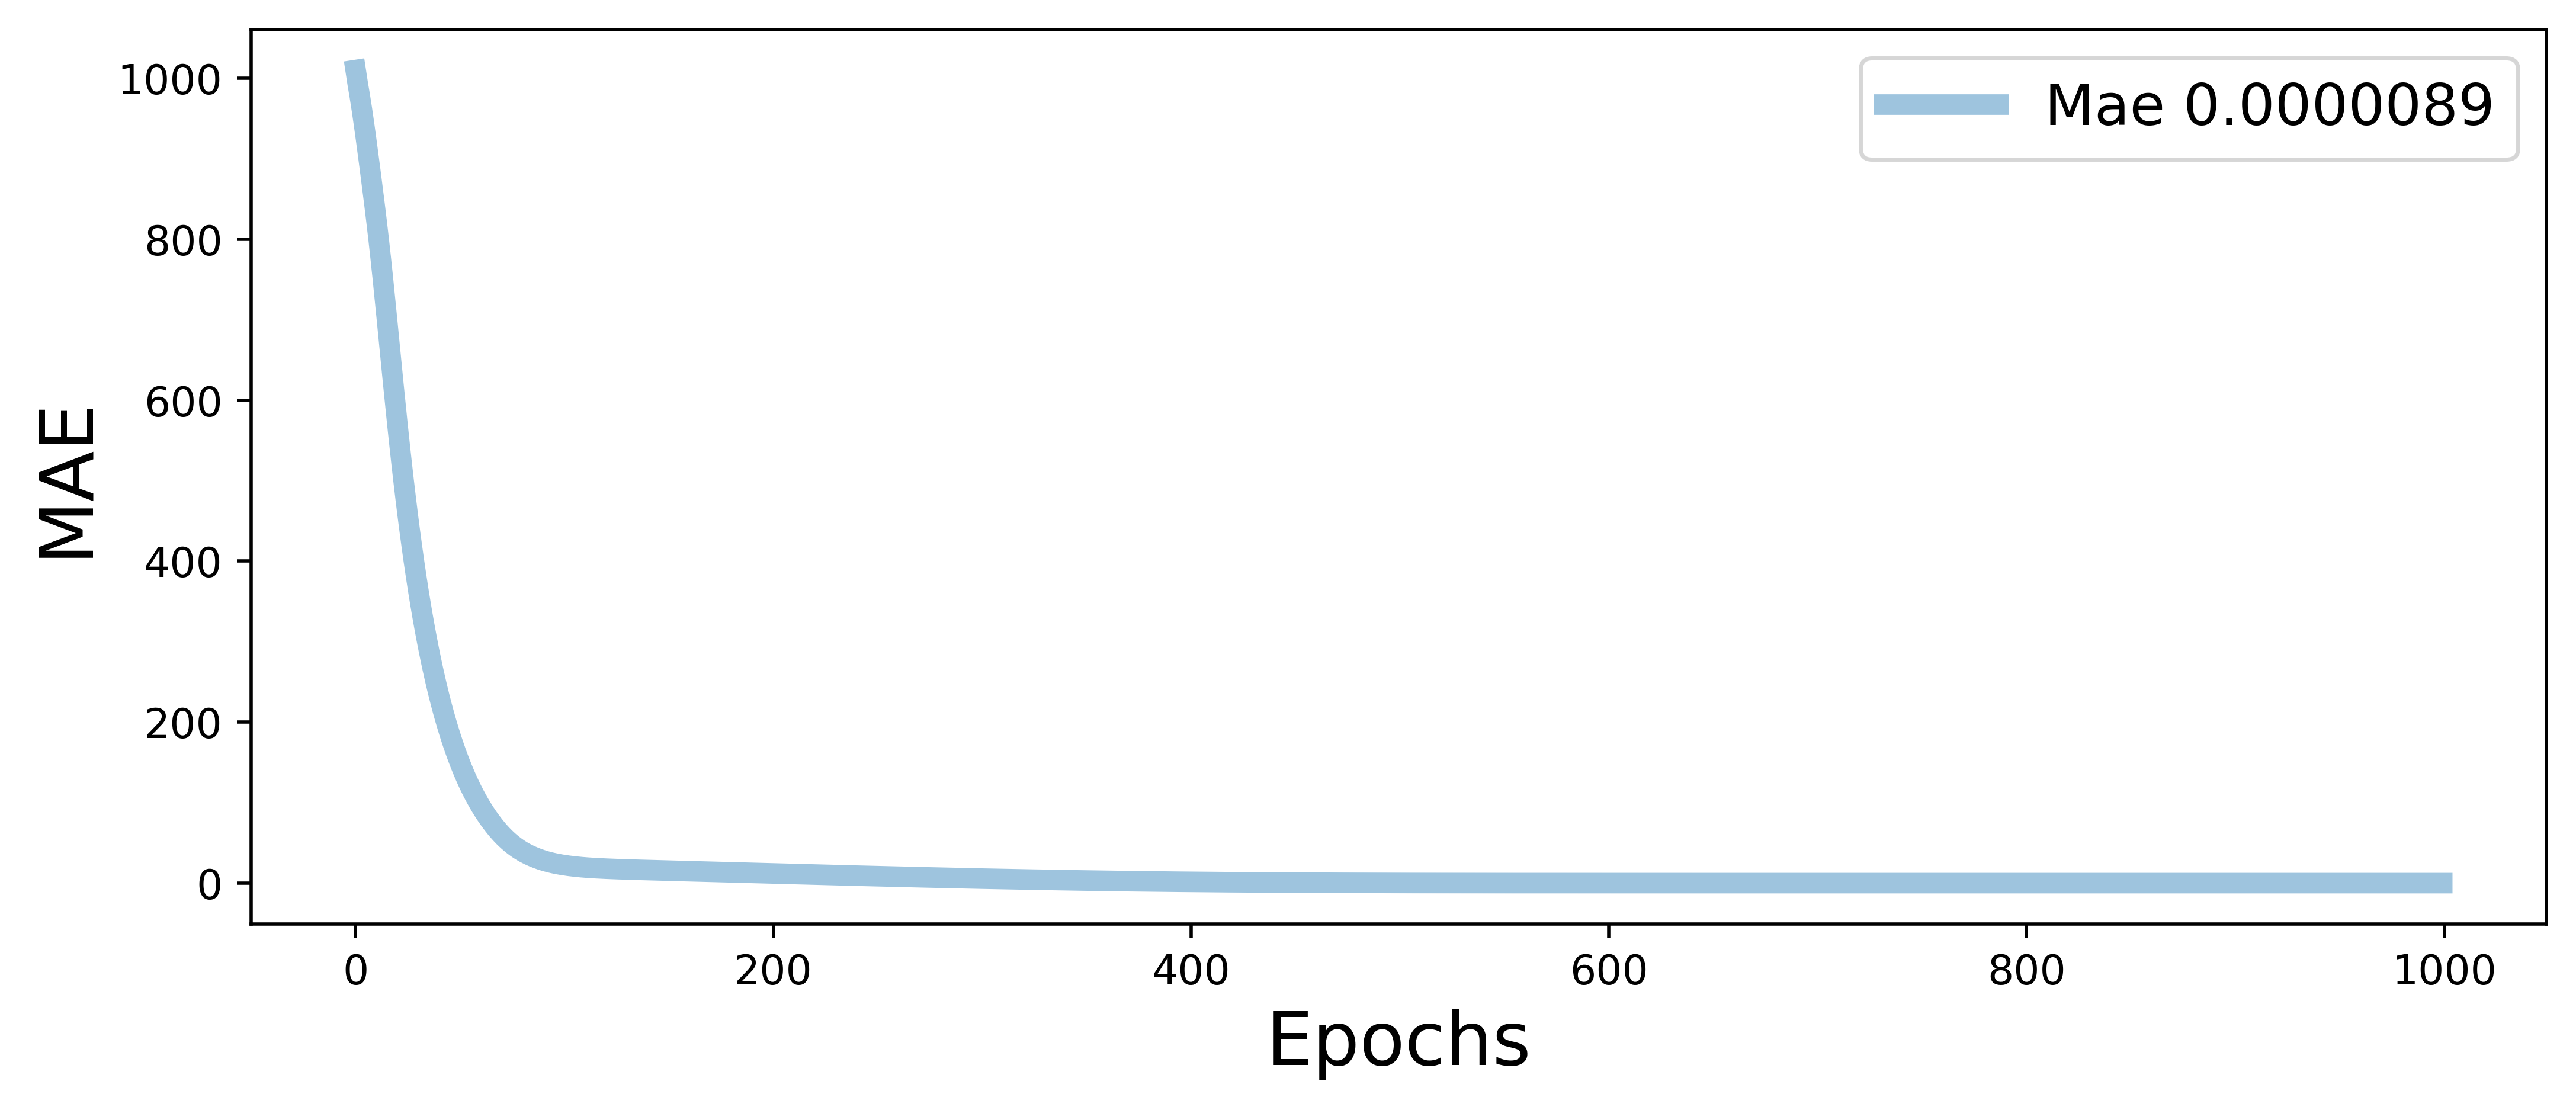

In [14]:
pict(rez)

In [15]:
rez = f('NALU')

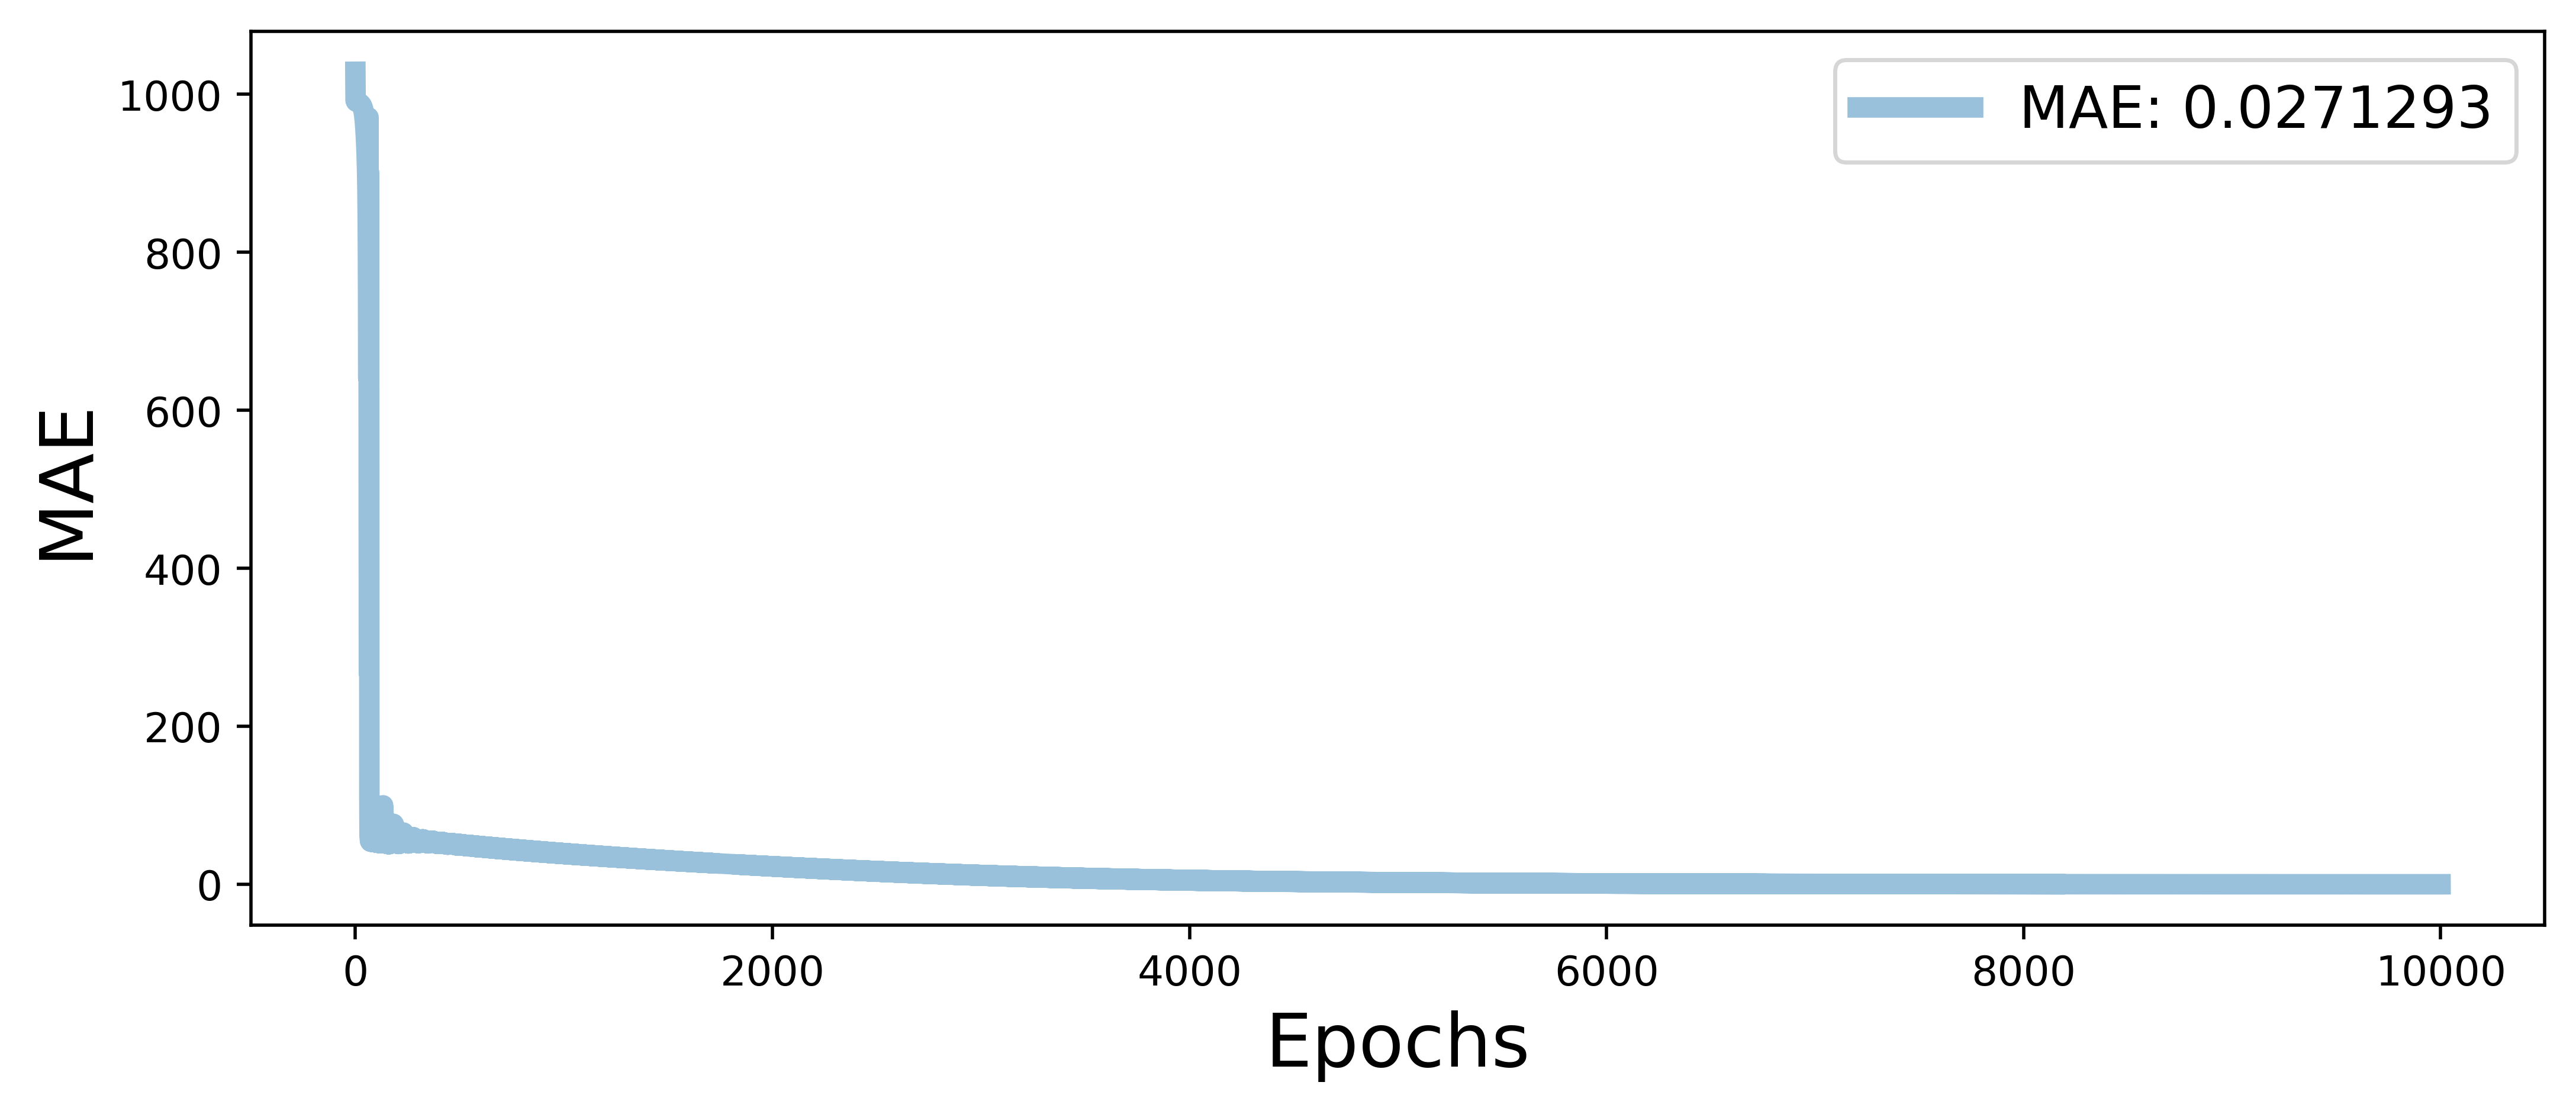

In [17]:
pict(rez)

### Multiplication

In [74]:
Func = 'PROD'
X_train, X_test, y_train, y_test = gen_data(int(1e3), 2, 0.2, [0, 1000], PROD)

In [75]:
rez = f('NAC')

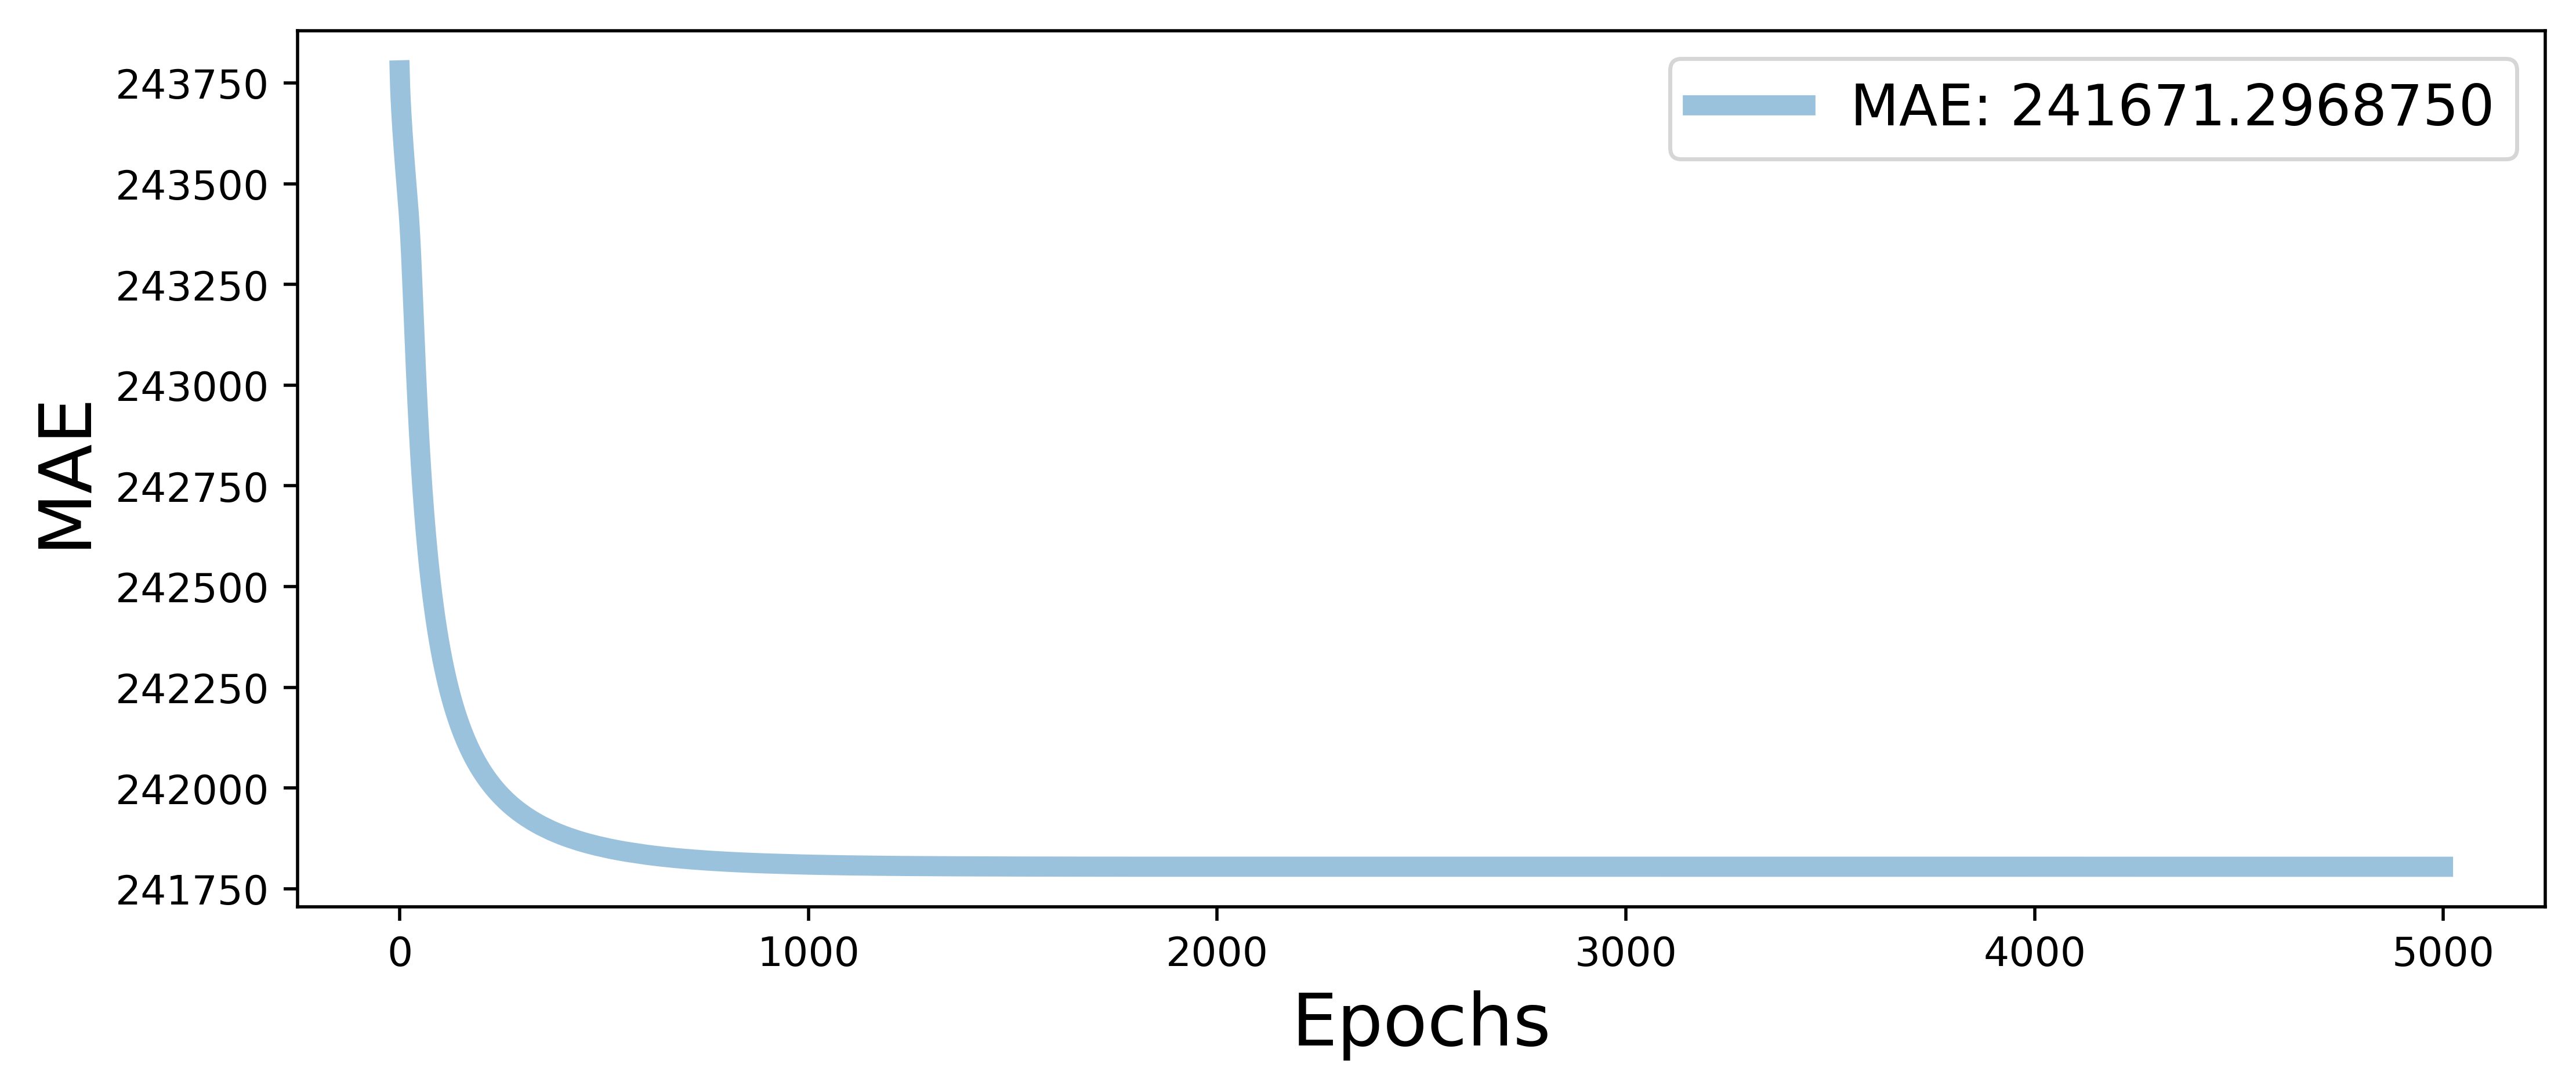

In [77]:
pict(rez)

In [59]:
rez = f('NALU')

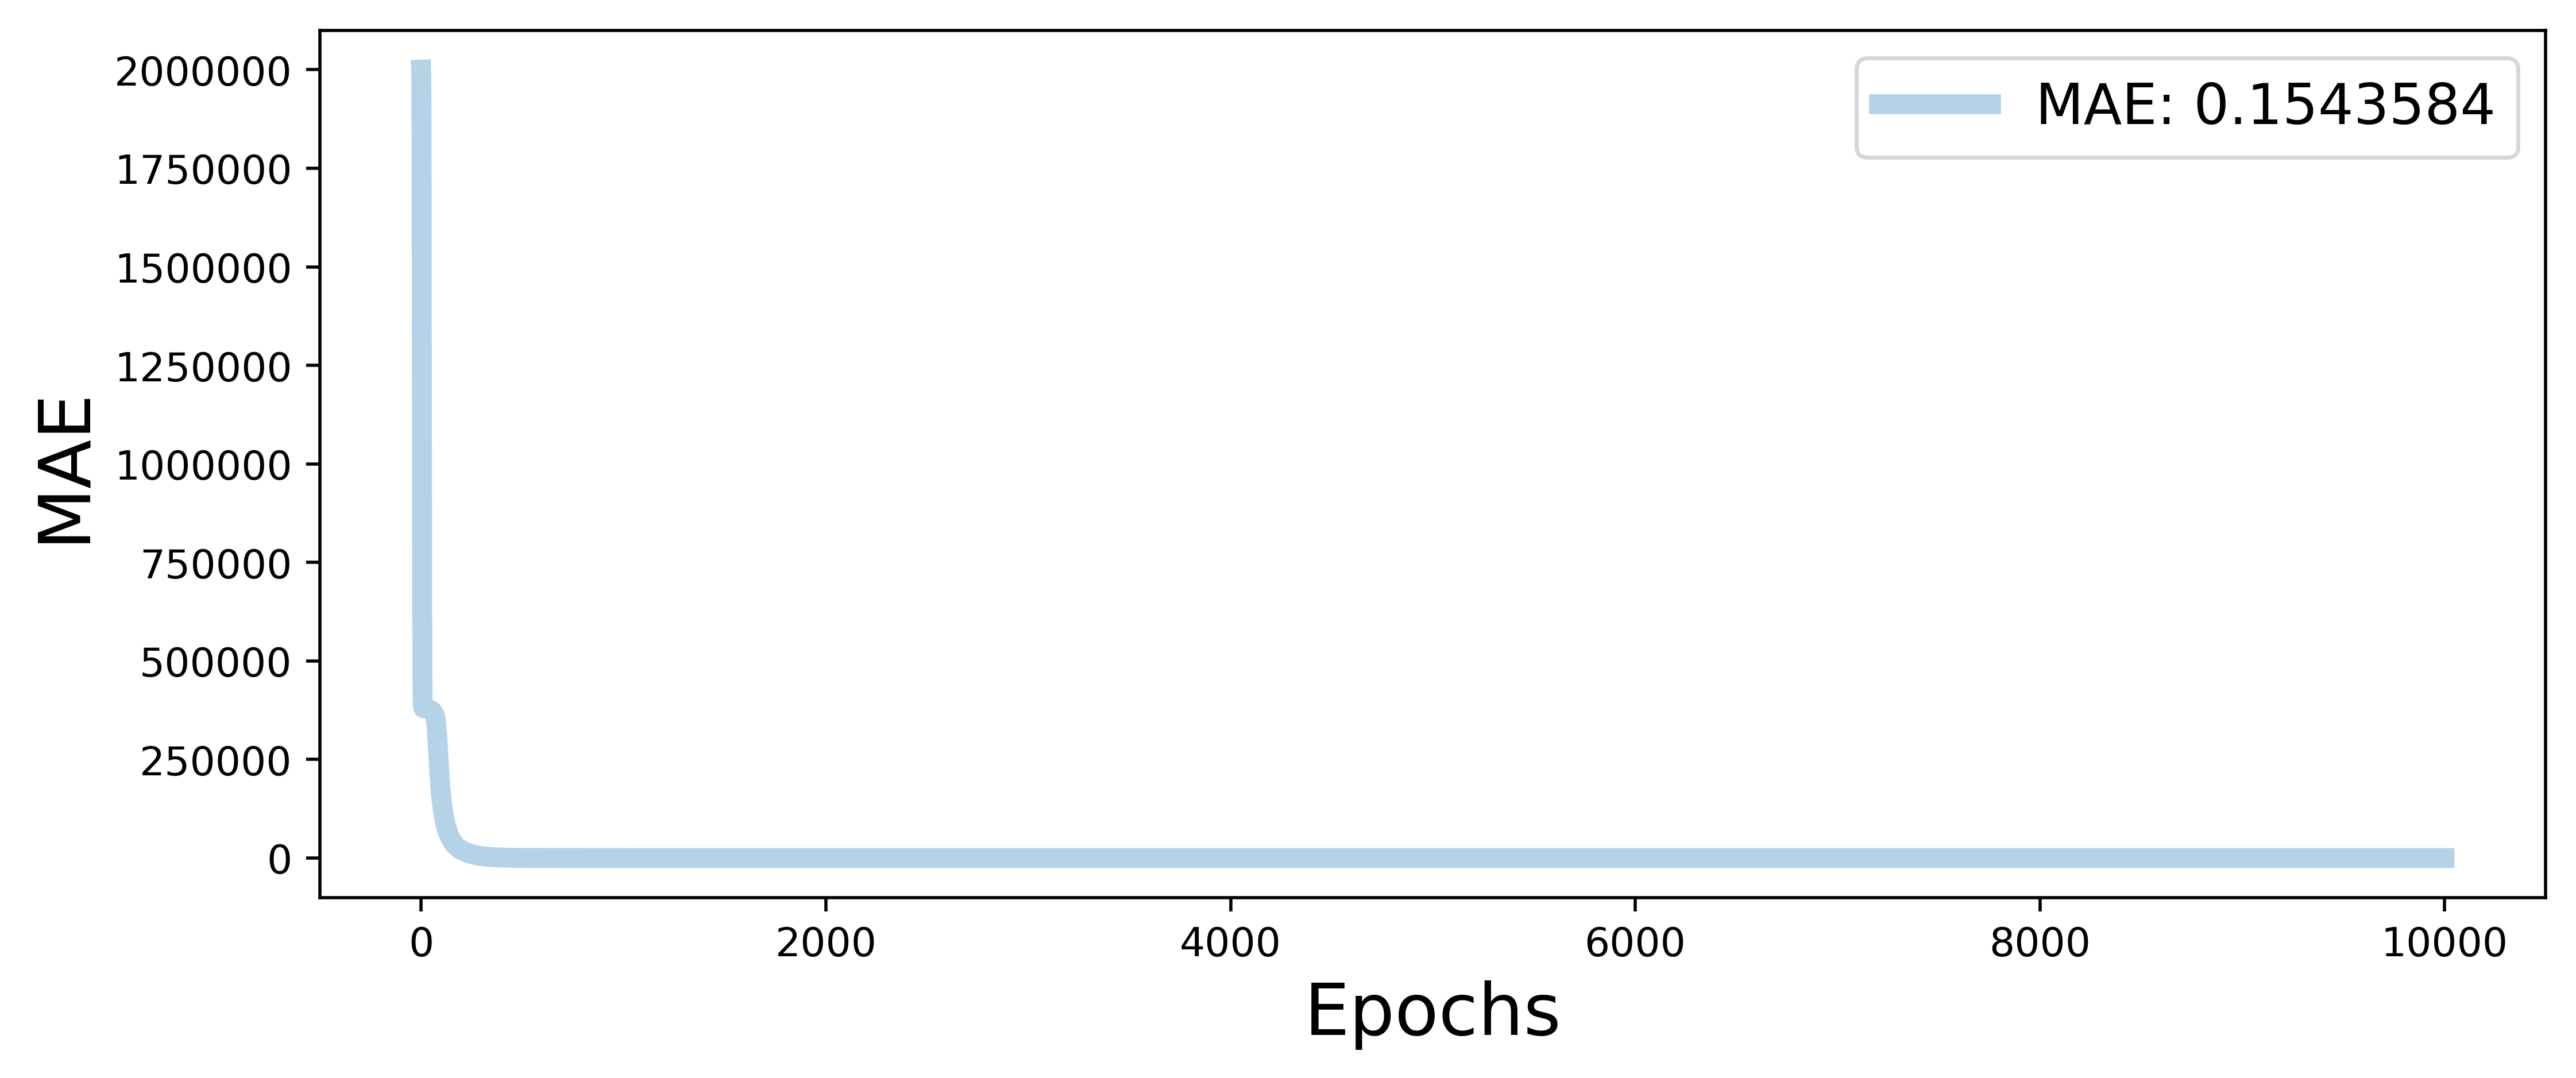

In [61]:
pict(rez)